In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot

### Data Generation

In [2]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9, -.8], [-.5, -.3]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.6, .4])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = .01
        self.noise_1 = .1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.3, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            self.plot_trajectory(n)
            self.pct_missing(n)

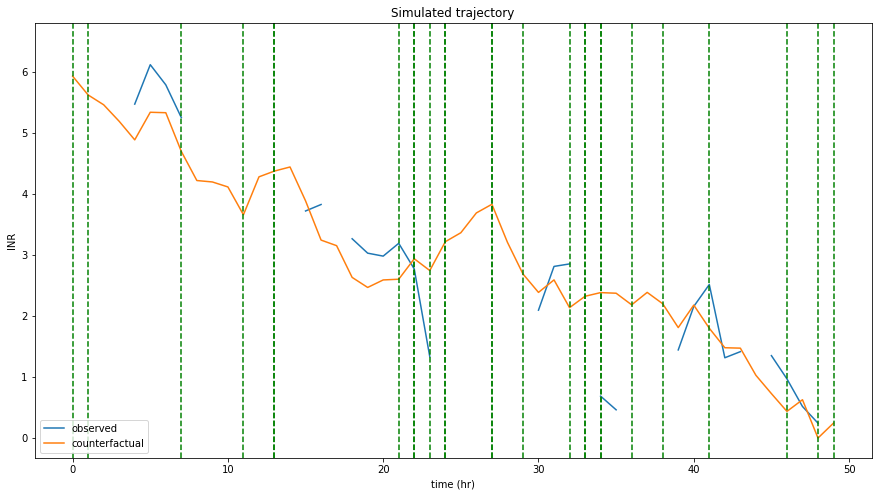

missing 34.0% of observations


In [139]:
model = Model(50, 1, 0.3)
model.run_simulation()

In [145]:
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = .8, single_effect=False)
#em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
em.run_EM(1)

mse in iteration 0 is 1.931907289829462


In [146]:
em.get_MSE()

1.931907289829462

In [147]:
em.sigma_1

0.423496735754792

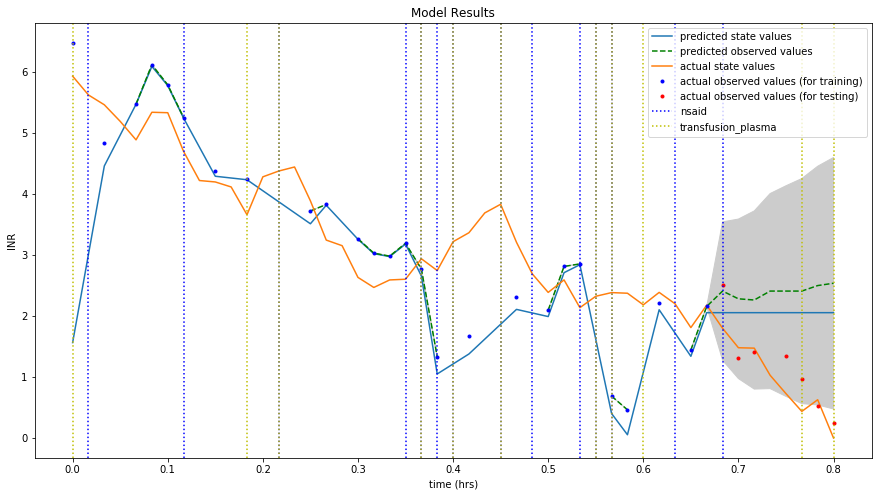

In [148]:
for n in range(model.y.shape[0]):
    plot(em, n, bin_size=1, true_model=True, model=model)

In [149]:
print('estimated params: {}'.format(em.params))
print('true params: {}'.format([model.A, model.b]))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated params: [-0.12693786  0.09008182 -0.14635104  0.12866051  0.35409219  0.        ]
true params: [array([[-0.9, -0.8],
       [-0.5, -0.3]]), array([0.6, 0.4])]
estimated initial state mean: 1.5591856884340147
true initial state mean: 6
estimated sigma_0: 0.034075301697838345
true sigma_0: 0.01
estimated sigma_1: 0.423496735754792
true sigma_1: 0.1
estimated sigma_2: 0.8630727055262781
true sigma_2: 0.01
estimated ratio: 0.49068489021044326
true ratio: 10.0


### Last Observation Carry Forward

In [9]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

In [10]:
em_1 = EM(LBCF(model.y), model.X, model.c, model.A.shape[0], 0, train_pct = 1)
em_1.run_EM(2000)

mse in iteration 0 is 0
mse in iteration 1 is 0
mse in iteration 2 is 0
mse in iteration 3 is 0
mse in iteration 4 is 0
mse in iteration 5 is 0
mse in iteration 6 is 0
mse in iteration 7 is 0
mse in iteration 8 is 0
mse in iteration 9 is 0
mse in iteration 10 is 0
mse in iteration 11 is 0
mse in iteration 12 is 0
mse in iteration 13 is 0
mse in iteration 14 is 0
mse in iteration 15 is 0
mse in iteration 16 is 0
mse in iteration 17 is 0
mse in iteration 18 is 0
mse in iteration 19 is 0
mse in iteration 20 is 0
mse in iteration 21 is 0
mse in iteration 22 is 0
mse in iteration 23 is 0
mse in iteration 24 is 0
mse in iteration 25 is 0
mse in iteration 26 is 0
mse in iteration 27 is 0
mse in iteration 28 is 0
mse in iteration 29 is 0
mse in iteration 30 is 0
mse in iteration 31 is 0
mse in iteration 32 is 0
mse in iteration 33 is 0
mse in iteration 34 is 0
mse in iteration 35 is 0
mse in iteration 36 is 0
mse in iteration 37 is 0
mse in iteration 38 is 0
mse in iteration 39 is 0
mse in ite

mse in iteration 367 is 0
mse in iteration 368 is 0
mse in iteration 369 is 0
mse in iteration 370 is 0
mse in iteration 371 is 0
mse in iteration 372 is 0
mse in iteration 373 is 0
mse in iteration 374 is 0
mse in iteration 375 is 0
mse in iteration 376 is 0
mse in iteration 377 is 0
mse in iteration 378 is 0
mse in iteration 379 is 0
mse in iteration 380 is 0
mse in iteration 381 is 0
mse in iteration 382 is 0
mse in iteration 383 is 0
mse in iteration 384 is 0
mse in iteration 385 is 0
mse in iteration 386 is 0
mse in iteration 387 is 0
mse in iteration 388 is 0
mse in iteration 389 is 0
mse in iteration 390 is 0
mse in iteration 391 is 0
mse in iteration 392 is 0
mse in iteration 393 is 0
mse in iteration 394 is 0
mse in iteration 395 is 0
mse in iteration 396 is 0
mse in iteration 397 is 0
mse in iteration 398 is 0
mse in iteration 399 is 0
mse in iteration 400 is 0
mse in iteration 401 is 0
mse in iteration 402 is 0
mse in iteration 403 is 0
mse in iteration 404 is 0
mse in itera

mse in iteration 734 is 0
mse in iteration 735 is 0
mse in iteration 736 is 0
mse in iteration 737 is 0
mse in iteration 738 is 0
mse in iteration 739 is 0
mse in iteration 740 is 0
mse in iteration 741 is 0
mse in iteration 742 is 0
mse in iteration 743 is 0
mse in iteration 744 is 0
mse in iteration 745 is 0
mse in iteration 746 is 0
mse in iteration 747 is 0
mse in iteration 748 is 0
mse in iteration 749 is 0
mse in iteration 750 is 0
mse in iteration 751 is 0
mse in iteration 752 is 0
mse in iteration 753 is 0
mse in iteration 754 is 0
mse in iteration 755 is 0
mse in iteration 756 is 0
mse in iteration 757 is 0
mse in iteration 758 is 0
mse in iteration 759 is 0
mse in iteration 760 is 0
mse in iteration 761 is 0
mse in iteration 762 is 0
mse in iteration 763 is 0
mse in iteration 764 is 0
mse in iteration 765 is 0
mse in iteration 766 is 0
mse in iteration 767 is 0
mse in iteration 768 is 0
mse in iteration 769 is 0
mse in iteration 770 is 0
mse in iteration 771 is 0
mse in itera

mse in iteration 1087 is 0
mse in iteration 1088 is 0
mse in iteration 1089 is 0
mse in iteration 1090 is 0
mse in iteration 1091 is 0
mse in iteration 1092 is 0
mse in iteration 1093 is 0
mse in iteration 1094 is 0
mse in iteration 1095 is 0
mse in iteration 1096 is 0
mse in iteration 1097 is 0
mse in iteration 1098 is 0
mse in iteration 1099 is 0
mse in iteration 1100 is 0
mse in iteration 1101 is 0
mse in iteration 1102 is 0
mse in iteration 1103 is 0
mse in iteration 1104 is 0
mse in iteration 1105 is 0
mse in iteration 1106 is 0
mse in iteration 1107 is 0
mse in iteration 1108 is 0
mse in iteration 1109 is 0
mse in iteration 1110 is 0
mse in iteration 1111 is 0
mse in iteration 1112 is 0
mse in iteration 1113 is 0
mse in iteration 1114 is 0
mse in iteration 1115 is 0
mse in iteration 1116 is 0
mse in iteration 1117 is 0
mse in iteration 1118 is 0
mse in iteration 1119 is 0
mse in iteration 1120 is 0
mse in iteration 1121 is 0
mse in iteration 1122 is 0
mse in iteration 1123 is 0
m

mse in iteration 1441 is 0
mse in iteration 1442 is 0
mse in iteration 1443 is 0
mse in iteration 1444 is 0
mse in iteration 1445 is 0
mse in iteration 1446 is 0
mse in iteration 1447 is 0
mse in iteration 1448 is 0
mse in iteration 1449 is 0
mse in iteration 1450 is 0
mse in iteration 1451 is 0
mse in iteration 1452 is 0
mse in iteration 1453 is 0
mse in iteration 1454 is 0
mse in iteration 1455 is 0
mse in iteration 1456 is 0
mse in iteration 1457 is 0
mse in iteration 1458 is 0
mse in iteration 1459 is 0
mse in iteration 1460 is 0
mse in iteration 1461 is 0
mse in iteration 1462 is 0
mse in iteration 1463 is 0
mse in iteration 1464 is 0
mse in iteration 1465 is 0
mse in iteration 1466 is 0
mse in iteration 1467 is 0
mse in iteration 1468 is 0
mse in iteration 1469 is 0
mse in iteration 1470 is 0
mse in iteration 1471 is 0
mse in iteration 1472 is 0
mse in iteration 1473 is 0
mse in iteration 1474 is 0
mse in iteration 1475 is 0
mse in iteration 1476 is 0
mse in iteration 1477 is 0
m

mse in iteration 1786 is 0
mse in iteration 1787 is 0
mse in iteration 1788 is 0
mse in iteration 1789 is 0
mse in iteration 1790 is 0
mse in iteration 1791 is 0
mse in iteration 1792 is 0
mse in iteration 1793 is 0
mse in iteration 1794 is 0
mse in iteration 1795 is 0
mse in iteration 1796 is 0
mse in iteration 1797 is 0
mse in iteration 1798 is 0
mse in iteration 1799 is 0
mse in iteration 1800 is 0
mse in iteration 1801 is 0
mse in iteration 1802 is 0
mse in iteration 1803 is 0
mse in iteration 1804 is 0
mse in iteration 1805 is 0
mse in iteration 1806 is 0
mse in iteration 1807 is 0
mse in iteration 1808 is 0
mse in iteration 1809 is 0
mse in iteration 1810 is 0
mse in iteration 1811 is 0
mse in iteration 1812 is 0
mse in iteration 1813 is 0
mse in iteration 1814 is 0
mse in iteration 1815 is 0
mse in iteration 1816 is 0
mse in iteration 1817 is 0
mse in iteration 1818 is 0
mse in iteration 1819 is 0
mse in iteration 1820 is 0
mse in iteration 1821 is 0
mse in iteration 1822 is 0
m

In [11]:
print('estimated params: {}'.format(em_1.params))
print('true params: {}'.format([model.A, model.b]))
print('estimated sigma_1: {}'.format(em_1.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em_1.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em_1.sigma_1/em_1.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated params: [-0.50483147 -0.42803506 -0.65233998 -0.34727637  0.          0.        ]
true params: [array([[-0.9, -0.8],
       [-0.5, -0.3]]), array([0.6, 0.4])]
estimated sigma_1: 0.3479455297561245
true sigma_1: 0.1
estimated sigma_2: 0.005402618929525999
true sigma_2: 0.01
estimated ratio: 64.40312268824995
true ratio: 10.0


### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little)
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values
4. The shift between the smoothened values and the true value is the difference between the estimated coefficient b and the true value of the coefficient. If the model underestimates, since y is the same for both underlying data generaing model and the estimating model, the estimated z would be larger than the true state value.  